In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path(os.path.abspath(__file__)).parent.parent.parent))

import os
import sys


from experiments.config import predict_config
from src.utils import preprocessing
from src import constants

from IPython.display import Image as IPImage
from IPython.display import display, HTML

import pickle 
from collections import OrderedDict

import time
import pandas as pd
import numpy as np 

from PIL import Image
from sentence_transformers import SentenceTransformer, util
from torchvision import transforms
import torch 

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


c:\Users\esthe\anaconda3\envs\SurfaceAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = predict_config.B_CNN


features_save_name = config.get("name") + '-' + config.get("dataset").replace('/', '_') + '-features'

In [3]:
# How to load images & embeddings from disc
with open(os.path.join(config.get('evaluation_path'), features_save_name), "rb") as f_in:
    stored_data = pickle.load(f_in)
    stored_ids = stored_data['image_ids']
    stored_coarse_features = stored_data['coarse_features']
    stored_fine_features = stored_data['fine_features']
    stored_predictions = stored_data['prediction']
    
    
    

In [13]:
stored_coarse_features.shape

torch.Size([5385, 262144])

In [89]:
#load the stored true labels
all_labels = pd.read_csv(os.path.join(config.get('data_path'), f'metadata/annotations_combined.csv'), usecols=['image_id', 'surface', 'smoothness'])
all_labels['image_id'] = all_labels['image_id'].astype(str)
all_labels = all_labels[~all_labels['smoothness'].isna()]
all_labels = all_labels[~all_labels['surface'].isna()]



In [90]:
#create intersection between stored_ids and all_labels['image_id']
filtered_stored_ids = [image_id for image_id in stored_ids if image_id in all_labels['image_id'].values]
true_labels = all_labels[all_labels['image_id'].isin(filtered_stored_ids)]

id_position = {image_id: position for position, image_id in enumerate(filtered_stored_ids)}


In [93]:
true_labels['position'] = true_labels['image_id'].map(id_position)
df_sorted = true_labels.sort_values(by='position')

In [96]:

filtered_stored_ids
final_coarse_labels = df_sorted['surface'].to_list()
final_fine_labels = df_sorted['smoothness'].to_list()


final_coarse_labels, final_fine_labels


(['concrete',
  'concrete',
  'concrete',
  'asphalt',
  'sett',
  'sett',
  'paving_stones',
  'sett',
  'unpaved',
  'sett',
  'sett',
  'unpaved',
  'unpaved',
  'unpaved',
  'paving_stones',
  'paving_stones',
  'concrete',
  'asphalt',
  'unpaved',
  'asphalt',
  'asphalt',
  'paving_stones',
  'asphalt',
  'asphalt',
  'asphalt',
  'unpaved',
  'unpaved',
  'concrete',
  'asphalt',
  'concrete',
  'unpaved',
  'paving_stones',
  'asphalt',
  'sett',
  'paving_stones',
  'concrete',
  'paving_stones',
  'unpaved',
  'unpaved',
  'sett',
  'unpaved',
  'asphalt',
  'asphalt',
  'sett',
  'sett',
  'asphalt',
  'asphalt',
  'asphalt',
  'asphalt',
  'unpaved',
  'paving_stones',
  'sett',
  'unpaved',
  'concrete',
  'sett',
  'asphalt',
  'sett',
  'unpaved',
  'unpaved',
  'concrete',
  'asphalt',
  'concrete',
  'concrete',
  'asphalt',
  'concrete',
  'asphalt',
  'concrete',
  'asphalt',
  'unpaved',
  'concrete',
  'asphalt',
  'asphalt',
  'unpaved',
  'unpaved',
  'asphalt',

In [117]:
#Now we filter also our features
filtered_stored_coarse_features = torch.stack([stored_coarse_features[id_position[image_id]] for image_id in filtered_stored_ids])
filtered_stored_fine_features = torch.stack([stored_fine_features[id_position[image_id]] for image_id in filtered_stored_ids])
#filtered_stored_predictions = [stored_predictions[id_position[image_id]] for image_id in filtered_stored_ids]
len(filtered_stored_coarse_features)

len(stored_coarse_features), len(filtered_stored_coarse_features)

(5385, 2052)

In [118]:
tsne_coarse = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30, random_state=config.get('seed')).fit_transform(filtered_stored_coarse_features)
tsne_fine = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30, random_state=config.get('seed')).fit_transform(filtered_stored_fine_features)


In [123]:

tsne_coarse.shape

(2052, 2)

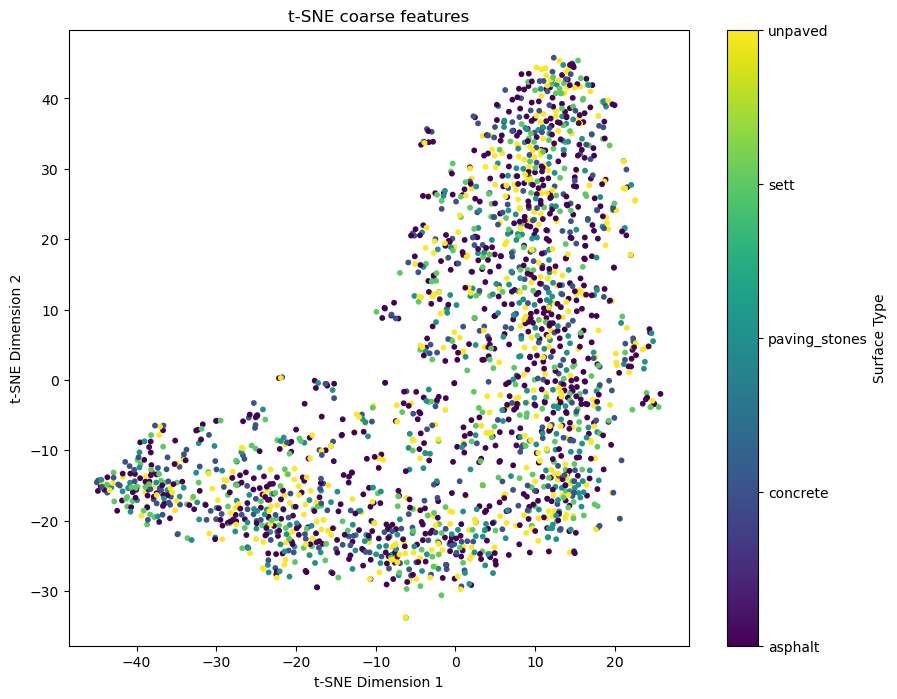

In [126]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
scatter_labels_encoded = label_encoder.fit_transform(final_coarse_labels)

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_coarse[:, 0], tsne_coarse[:, 1], c=scatter_labels_encoded, cmap='viridis', s=10)
plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)), label='Surface Type').set_ticklabels(label_encoder.classes_)
plt.title('t-SNE coarse features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [ ]:
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 


In [ ]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)



# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)
 
# for every class, we'll add a scatter plot separately
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    color = np.array(colors_per_class[label], dtype=np.float) / 255
 
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=label)
 
# build a legend using the labels we set previously
ax.legend(loc='best')
 
# finally, show the plot
plt.show()